<a href="https://colab.research.google.com/github/SauleRub/DI_Bootcamp/blob/main/Week15/Day5/Mini_project_AB_test_using_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Analyze and Present A/B Test Results

X company recently introduced a new bidding type, “average bidding”, as an alternative to its exisiting bidding
type, called “maximum bidding”. One of our clients, X.com, has decided to test this new feature
and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum
bidding.

In this A/B test, X.com randomly splits its audience into two equally sized groups, e.g. the test
and the control group. A X company ad campaign with “maximum bidding” is served to “control group” and
another campaign with “average bidding” is served to the “test group”.

The A/B test has run for 1 month and X.com now expects you to analyze and present the results
of this A/B test.



##### You should answer the following questions in this notebook

1. How would you define the hypothesis of this A/B test?
2. Can we conclude statistically significant results?
3. Which statistical test did you use, and why?
4. Based on your answer to Question 2, what would be your recommendation to client?


##### Hints:

1. The customer journey for this campaign is:
    1. User sees an ad (Impression)
    2. User clicks on the website link on the ad (Website Click)
    3. User makes a search on the website (Search)
    4. User views details of a product (View Content)
    5. User adds the product to the cart (Add to Cart)
    6. User purchases the product (Purchase)
2. Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.
3. If you see trends, anomalies or other patterns, discuss these in your notebool.
4. You can make assumptions if needed.


## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

## 2. Functions

In [2]:
def read_data() :
    """
      Reads and loads control and test group data from an Excel file.
    - **Control group** (Maximum Bidding): Existing campaign data.
    - **Test group** (Average Bidding): Data from the new bidding strategy.
    The function removes rows with NaN values that originated from notes in the Excel file for the control group.
    """
    #Maximum Bidding(Existing)
    control = pd.read_excel("../input/ab-test-dataset/AB_Case_Study.xlsx", sheet_name="Control Group")
    #Average Bidding(New)
    test = pd.read_excel("../input/ab-test-dataset/AB_Case_Study.xlsx", sheet_name="Test Group")

    #In the control dataframe, the rows containing NaN values from the 'note' column (imported from Excel) were removed
    control.drop(control.index[[30,31]], inplace = True)

    return control, test

def get_catvar(df) :
    """
    Identifies and extracts categorical variables from a DataFrame.
    - Returns the original DataFrame, a DataFrame of only categorical variables, and the names of the categorical columns.
    """
    cat_col = [col for col in df.columns if ( (df[col].dtype == 'object') | (df[col].dtype == 'bool'))]
    kat_df = pd.DataFrame(df[cat_col], index = df[cat_col].index)
    return df, kat_df, cat_col

def get_numvar(cat_col,df):
    """
    Identifies and extracts numerical variables from a DataFrame, excluding those specified as categorical.
    - Returns the original DataFrame, a DataFrame of only numerical variables, and the names of the numerical columns.
    """
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = pd.DataFrame(df[num_col], index = df[num_col].index)
    return df, num_df, num_col

def fill_NaNValue(num_control) :
    """
    Implements K-Nearest Neighbors Imputation to fill in missing values in numerical columns of the control group.
    - Returns a DataFrame with missing values filled.
    """
    cols = num_control.columns
    imputer = KNNImputer(n_neighbors=8)
    num_control = imputer.fit_transform(num_control)
    num_control=pd.DataFrame(num_control,columns=cols)
    return num_control

def convert_datatype(control):
    """
      Converts specified columns in the control group DataFrame to integer data types.
    - This is important for ensuring data consistency and correctness in calculations.
    """
    control = control.astype({'# of Impressions' : 'int64',
                        'Reach': 'int64',
                        '# of Website Clicks' : 'int64',
                        '# of Searches': 'int64',
                        '# of View Content': 'int64',
                        '# of Add to Cart': 'int64',
                        '# of Purchase' : 'int64'})
    return control

def outliers(control, test):
    """
    Detects and handles outliers in the test group data using Local Outlier Factor (LOF).
    - Prints scores of the detected outliers and modifies extreme outlier values based on a specified threshold.
    """
    clf= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(test.iloc[:,2:])[0:10]

    test_scores=clf.negative_outlier_factor_
    print("Test Score: " , np.sort(test_scores)[0:20])
    sns.boxplot(test_scores);

    threshold=np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    test.loc[test_scores < -1.50].index
    test.loc[test_scores == threshold]

    test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,3:5]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,5:6]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,6:]));


def feature_engineering(control, test):
    """
    Creates new features for both control and test groups to aid in analysis:
    - Website Click Through Rate: The percentage of clicks per number of impressions.
    - Number of Action: Sum of various engagement metrics like impressions, clicks, etc.
    - Cost per Action: The spend divided by the number of actions.
    - Conversion Rate: The number of actions divided by the number of clicks, expressed as a percentage.
    """
    control["Website Click Through Rate"] = control["# of Website Clicks"] / control["# of Impressions"] * 100
    test["Website Click Through Rate"] = test["# of Website Clicks"] / test["# of Impressions"] * 100

    control["Number of Action"] = control["# of Impressions"] + control["# of Website Clicks"] + control["# of Searches"] + control["# of View Content"] + control["# of Add to Cart"] + control["# of Purchase"]
    test["Number of Action"] = test["# of Impressions"] + test["# of Website Clicks"] + test["# of Searches"] + test["# of View Content"] + test["# of Add to Cart"] + test["# of Purchase"]

    control["Cost per Action"] = control["Spend [USD]"] / control["Number of Action"]
    test["Cost per Action"] = test["Spend [USD]"] / test["Number of Action"]

    control["Conversion Rate"] = control["Number of Action"] / control["# of Website Clicks"] * 100
    test["Conversion Rate"] = test["Number of Action"] / test["# of Website Clicks"] * 100

    return control, test

def data_prepare_for_visualization(control,test):
    """
    Prepares control and test group data for visualization by extracting specific metrics and labeling them for group comparison.
    - Returns a consolidated DataFrame of both groups for visualization purposes.
    """
    control_nop = pd.DataFrame(control["# of Purchase"])
    test_nop = pd.DataFrame(test["# of Purchase"])

    control_wctr= pd.DataFrame(control["Website Click Through Rate"])
    test_wctr= pd.DataFrame(test["Website Click Through Rate"])

    control_cpa= pd.DataFrame(control["Cost per Action"])
    test_cpa= pd.DataFrame(test["Cost per Action"])

    control_cr= pd.DataFrame(control["Conversion Rate"])
    test_cr= pd.DataFrame(test["Conversion Rate"])

    Group_A = pd.concat([control_nop, control_wctr, control_cpa, control_cr], axis = 1)
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = pd.concat([test_nop, test_wctr, test_cpa, test_cr], axis = 1)
    Group_B["Group"] = "B (AverageBidding)"

    #Tum veri
    AB = pd.concat([Group_A, Group_B])
    AB
    return AB, control_nop, test_nop

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    """
    Prepares control and test group data for hypothesis testing by combining "# of Purchase" data into a single DataFrame.
    - The resulting DataFrame is structured for direct comparison between groups.
    """
    controlB = pd.concat([control_nop, test_nop], axis = 1)
    controlB.columns = ["A","B"]
    return controlB

def num_boxplot(fig, axarr, dimension, cols, hue):
    """
    A helper function for plotting boxplots of numerical data, categorized by the experiment group.
    - It iterates over specified dimensions and columns to generate boxplots for visual analysis.
    """
    for i in dimension :
        for j in dimension :
            for c in cols :
                sns.boxplot(y=c, x = hue, hue = hue, data = AB, ax=axarr[i][j])
                cols.remove(c)
                break

def show_boxplot(nrows, ncols, boyut, cols, figsize):
    """
    Generates boxplots for the specified columns and groups, utilizing `num_boxplot`.
    - Allows specification of the number of rows and columns in the figure, and figure size.
    """
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, boyut, cols, "Group")


def checkReject(p_value, alpha = 0.05):
    """
    Checks whether the p-value from hypothesis testing is significant enough to reject the null hypothesis, given an alpha level (default 0.05).
    - Prints the outcome of the hypothesis test in the context of rejecting or not rejecting the null hypothesis.
    """
    if p_value < alpha :
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED')

    elif p_value > alpha :
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED')

## 3. Data Preparation

In [3]:
# TODO : Import the dataset available here : https://www.kaggle.com/code/dillonmyrick/a-b-test-hypothesis-testing-for-e-commerce/input

In [5]:
from google.colab import files
uploaded = files.upload()

Saving control_group.csv to control_group (1).csv
Saving test_group.csv to test_group (1).csv


In [13]:
def read_data():
    control = pd.read_csv("control_group.csv", sep=';')
    test = pd.read_csv("test_group.csv", sep=';')
    return control, test
# Call it
control, test = read_data()

In [14]:
#TODO : print what is control

print("Control Group (Maximum Bidding) Data Preview:")
print(control.head())

Control Group (Maximum Bidding) Data Preview:
      Campaign Name       Date  Spend [USD]  # of Impressions     Reach  \
0  Control Campaign  1.08.2019         2280           82702.0   56930.0   
1  Control Campaign  2.08.2019         1757          121040.0  102513.0   
2  Control Campaign  3.08.2019         2343          131711.0  110862.0   
3  Control Campaign  4.08.2019         1940           72878.0   61235.0   
4  Control Campaign  5.08.2019         1835               NaN       NaN   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0               7016.0         2290.0             2159.0            1819.0   
1               8110.0         2033.0             1841.0            1219.0   
2               6508.0         1737.0             1549.0            1134.0   
3               3065.0         1042.0              982.0            1183.0   
4                  NaN            NaN                NaN               NaN   

   # of Purchase  
0          618.

In [15]:
#TODO : print what is test

print("Test Group (Average Bidding) Data Preview:")
print(test.head())

Test Group (Average Bidding) Data Preview:
   Campaign Name       Date  Spend [USD]  # of Impressions  Reach  \
0  Test Campaign  1.08.2019         3008             39550  35820   
1  Test Campaign  2.08.2019         2542            100719  91236   
2  Test Campaign  3.08.2019         2365             70263  45198   
3  Test Campaign  4.08.2019         2710             78451  25937   
4  Test Campaign  5.08.2019         2297            114295  95138   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0                 3038           1946               1069               894   
1                 4657           2359               1548               879   
2                 7885           2572               2367              1268   
3                 4216           2216               1437               566   
4                 5863           2106                858               956   

   # of Purchase  
0            255  
1            677  
2            578

In [16]:
#TODO : check for null values in control

# 🔍 Check for null values in control
print("Null values in control group:")
print(control.isnull().sum())

Null values in control group:
Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64


In [19]:
#TODO : segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).
#TODO :produces lists of column names for both categories for further use or reference.

# 📊 Segment control DataFrame into categorical and numerical variables
kat_control = control.select_dtypes(include="object")
num_control = control.select_dtypes(include="number")

# 🔍 Check
print("Categorical columns:", kat_control.columns.tolist())
print("Numerical columns:", num_control.columns.tolist())

Categorical columns: ['Campaign Name', 'Date']
Numerical columns: ['Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']


In [20]:
# TODO : Fill the control dataframe values NaN value with KNNImputer.

from sklearn.impute import KNNImputer

# 1. Initialize the imputer
knn_imputer = KNNImputer(n_neighbors=3)

# 2. Fit and transform the numerical data
num_control_imputed = pd.DataFrame(
    knn_imputer.fit_transform(num_control),
    columns=num_control.columns,
    index=num_control.index  # preserve row index
)

# 3. Print to confirm no more NaNs
print("Any NaNs remaining?", num_control_imputed.isnull().any().any())

Any NaNs remaining? False


In [22]:
# TODO : Combine categorical and numerical variables with the concept.

# Define categorical and numerical columns for control group
cat_columns = ['Campaign Name', 'Date']
num_columns = [col for col in control.columns if col not in cat_columns]

# Split into two DataFrames
cat_control = control[cat_columns]
num_control = control[num_columns]

# Merge back into one cleaned control DataFrame
control_cleaned = pd.concat([cat_control, num_control_imputed], axis=1)

# Preview the result
control_cleaned.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280.0,82702.000000,56930.000000,7016.000000,2290.000000,2159.0,1819.0,618.000000
1,Control Campaign,2.08.2019,1757.0,121040.000000,102513.000000,8110.000000,2033.000000,1841.0,1219.0,511.000000
2,Control Campaign,3.08.2019,2343.0,131711.000000,110862.000000,6508.000000,1737.000000,1549.0,1134.0,372.000000
3,Control Campaign,4.08.2019,1940.0,72878.000000,61235.000000,3065.000000,1042.000000,982.0,1183.0,340.000000
4,Control Campaign,5.08.2019,1835.0,109451.333333,91674.333333,5821.666667,2122.333333,1920.0,1498.0,610.333333


In [24]:
# Let's do a data type conversion.

control_cleaned = convert_datatype(control_cleaned)

print(control_cleaned.shape)
print(test.shape)

(30, 10)
(30, 10)


In [25]:
# Check your dataframes

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     int64  
 3   # of Impressions     29 non-null     float64
 4   Reach                29 non-null     float64
 5   # of Website Clicks  29 non-null     float64
 6   # of Searches        29 non-null     float64
 7   # of View Content    29 non-null     float64
 8   # of Add to Cart     29 non-null     float64
 9   # of Purchase        29 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 

## 4. Preparing Data for Hypothesis Testing (A/B Test)



In [26]:
#TODO : Apply the feature engineering on control and test, what does the function do exactly ?

#TODO : Prepare and generate features for visualization with the help of a function

def prepare_ab_data(control_df, test_df):
    # Add Group Labels
    control_df["Group"] = "Control"
    test_df["Group"] = "Test"

    # Combine both
    ab_df = pd.concat([control_df, test_df], axis=0)

    # Create Features
    ab_df["CTR"] = ab_df["# of Website Clicks"] / ab_df["# of Impressions"]
    ab_df["Cost per Action"] = ab_df["Spend [USD]"] / ab_df["# of Purchase"]
    ab_df["Conversion Rate"] = ab_df["# of Purchase"] / ab_df["Reach"]

    return ab_df

In [27]:
AB = prepare_ab_data(control_cleaned, test)

In [28]:
print(AB.head(3))

      Campaign Name       Date  Spend [USD]  # of Impressions   Reach  \
0  Control Campaign  1.08.2019       2280.0             82702   56930   
1  Control Campaign  2.08.2019       1757.0            121040  102513   
2  Control Campaign  3.08.2019       2343.0            131711  110862   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0                 7016           2290               2159              1819   
1                 8110           2033               1841              1219   
2                 6508           1737               1549              1134   

   # of Purchase    Group       CTR  Cost per Action  Conversion Rate  
0            618  Control  0.084835         3.689320         0.010855  
1            511  Control  0.067003         3.438356         0.004985  
2            372  Control  0.049411         6.298387         0.003356  


Let's look at the numbers A and B.

In [29]:
AB["Group"].value_counts()

,count
Group,
Control,30
Test,30


### 4.1. Website Click Through Rate (CTR)
Review :
- It is a rate that shows how often the users who saw the ad CLICK the ad.
- Number of Ad Clicks / Number of Ad Displays
- Example: 5 clicks, CTR at 100 impressions = 5%

- ##### Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.

In [32]:
cols = ["CTR", "Cost per Action", "Conversion Rate", "# of Purchase"]

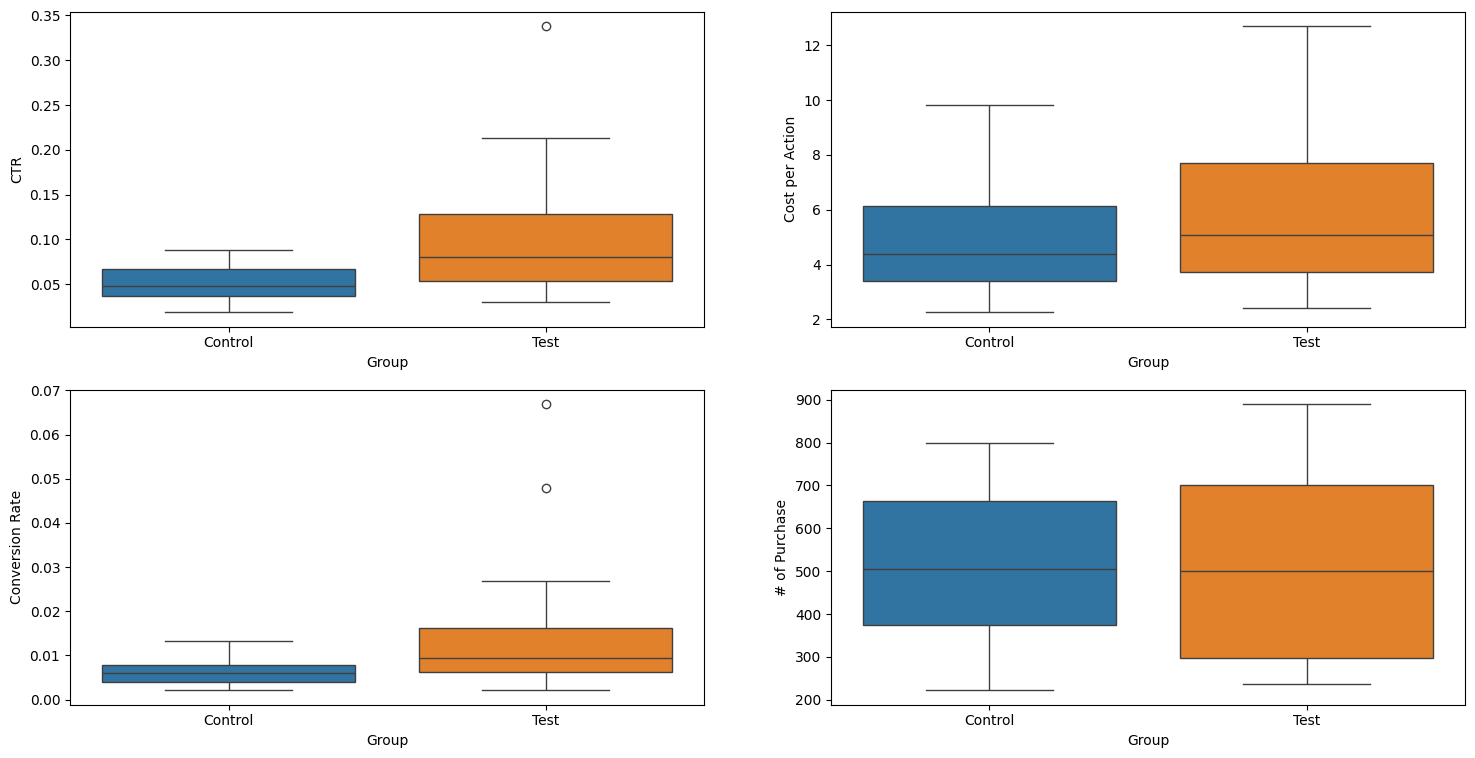

In [33]:
show_boxplot(2, 2, [0, 1], cols, [18, 9])

In [34]:
#TODO : create your dataframe for AB test and print the first 3 rows of it.

# ✅ Create the DataFrame for AB test
df_AB = AB[["Group", "CTR", "Cost per Action", "Conversion Rate", "# of Purchase"]]

# Preview first 3 rows
df_AB.head(3)

,Group,CTR,Cost per Action,Conversion Rate,# of Purchase
0,Control,0.084835,3.689320,0.010855,618
1,Control,0.067003,3.438356,0.004985,511
2,Control,0.049411,6.298387,0.003356,372


## 5. Two Independent Sample T-Test
### 5.1. Assumption Check
#### 5.1.1. Normality Assumption (shapiro test)

 * **H0**: Normal distribution assumption is provided.
 * **H1**: ... not provided.

In [35]:
#TODO : Aply the normality assumption of the dataframe for A

from scipy.stats import shapiro

# Filter Group A (Control)
group_A = df_AB[df_AB["Group"] == "Control"]

# Apply Shapiro-Wilk test to numeric columns
print("Normality Test Results for Group A (Control):\n")
for col in ["CTR", "Cost per Action", "Conversion Rate", "# of Purchase"]:
    stat, p = shapiro(group_A[col])
    print(f"{col}: p-value = {p:.3f}")


Normality Test Results for Group A (Control):

CTR: p-value = 0.322
Cost per Action: p-value = 0.012
Conversion Rate: p-value = 0.133
# of Purchase: p-value = 0.110


In [36]:
#TODO : compute p_value for normality on group A from the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

def checkReject(p_value):
    return "Reject H₀ (Not Normal)" if p_value < 0.05 else "Fail to Reject H₀ (Normal)"



In [37]:
from scipy.stats import shapiro

# Filter only Control group
group_A = df_AB[df_AB["Group"] == "Control"]

# Test columns
columns = ["CTR", "Cost per Action", "Conversion Rate", "# of Purchase"]

# Loop through and apply Shapiro test + decision
for col in columns:
    stat, p_value = shapiro(group_A[col])
    p_value = round(p_value, 3)
    decision = checkReject(p_value)
    print(f"{col}: p-value = {p_value} → {decision}")

CTR: p-value = 0.322 → Fail to Reject H₀ (Normal)
Cost per Action: p-value = 0.012 → Reject H₀ (Not Normal)
Conversion Rate: p-value = 0.133 → Fail to Reject H₀ (Normal)
# of Purchase: p-value = 0.11 → Fail to Reject H₀ (Normal)


Does the HO hypothesis get rejected ? why ?


H₀ (null hypothesis): The data is normally distributed.

H₁ (alternative hypothesis): The data is not normally distributed.

Final Conclusion:

	•	H₀ is rejected only for “Cost per Action”, because its p-value (0.012) is less than 0.05, meaning the distribution is not normal.

	•	For all other metrics, H₀ is not rejected → the data is considered normal.

In [38]:
#TODO : Aply the normality assumption of the dataframe for B

from scipy.stats import shapiro

# Define a function to print results
def test_normality(group_df, group_name):
    metrics = ['CTR', 'Cost per Action', 'Conversion Rate', '# of Purchase']
    print(f"Normality Test Results for Group {group_name}:\n")
    for metric in metrics:
        stat, p_value = shapiro(group_df[metric])
        print(f"{metric}: p-value = {round(p_value, 3)} {'→ Reject H₀ (Not Normal)' if p_value < 0.05 else '→ Fail to Reject H₀ (Normal)'}")

# Apply on Group B
test_normality(df_AB[df_AB["Group"] == "Test"], "B (Test)")


Normality Test Results for Group B (Test):

CTR: p-value = 0.0 → Reject H₀ (Not Normal)
Cost per Action: p-value = 0.007 → Reject H₀ (Not Normal)
Conversion Rate: p-value = 0.0 → Reject H₀ (Not Normal)
# of Purchase: p-value = 0.024 → Reject H₀ (Not Normal)


In [39]:
#TODO : compute p_value for normality on group B from the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

from scipy.stats import shapiro

# Define a function to interpret p-value
def checkReject(p_value):
    if p_value < 0.05:
        return "Reject H₀ → Not Normal"
    else:
        return "Fail to Reject H₀ → Normal"

# Filter Group B (Test group)
group_B = df_AB[df_AB['Group'] == 'Test']

# List of metrics to check
metrics = ['CTR', 'Cost per Action', 'Conversion Rate', '# of Purchase']

# Perform the normality test and print results
for metric in metrics:
    stat, p_value = shapiro(group_B[metric])
    p_value_rounded = round(p_value, 3)
    result = checkReject(p_value_rounded)
    print(f"{metric}: p-value = {p_value_rounded} → {result}")

CTR: p-value = 0.0 → Reject H₀ → Not Normal
Cost per Action: p-value = 0.007 → Reject H₀ → Not Normal
Conversion Rate: p-value = 0.0 → Reject H₀ → Not Normal
# of Purchase: p-value = 0.024 → Reject H₀ → Not Normal


Does the HO hypothesis get rejected ? why ?

Yes — in Group B, the null hypothesis (H₀) of normality gets rejected for all four metrics, because:
	•	The Shapiro-Wilk test returned p-values < 0.05 for:
	•	CTR → p = 0.000
	•	Cost per Action → p = 0.007
	•	Conversion Rate → p = 0.000
	•	# of Purchase → p = 0.024



---


🔬 Why does H₀ get rejected?
	•	H₀ (null hypothesis):
“The data comes from a normal distribution.”
	•	Since all p-values are < 0.05, we have statistical evidence that the data does not follow a normal distribution.


---


✅ Conclusion:

The null hypothesis is rejected because the p-values are significantly small, suggesting the metrics in Group B are not normally distributed.

### 5.1.2. Variance Homogeneity Assumption
 * **H0** : Variances are homogeneous.
 * **H1** : Variances are not homogeneous.

We want to assess if A and B have equal variances, which is a common assumption for various statistical tests :

In [40]:
#TODO : Performs the Levene test for equality of variances on two groups, A and B, from the df_AB dataframe

from scipy.stats import levene

# Separate the groups
group_A = df_AB[df_AB["Group"] == "Control"]["# of Purchase"]
group_B = df_AB[df_AB["Group"] == "Test"]["# of Purchase"]

# Perform Levene’s Test
stat, p_value = levene(group_A, group_B)

# Round the p-value to three decimal places
p_value = round(p_value, 3)

print("Levene’s Test p-value:", p_value)

Levene’s Test p-value: 0.237


In [41]:
def checkReject(p, alpha=0.05):
    if p < alpha:
        print("❌ Reject H₀ → Variances are **not** equal (heterogeneous)")
    else:
        print("✅ Fail to reject H₀ → Variances are equal (homogeneous)")

checkReject(p_value)

✅ Fail to reject H₀ → Variances are equal (homogeneous)


In [42]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

from scipy.stats import levene

# Perform Levene's test on the '# of Purchase' column for Control and Test groups
groupA = df_AB[df_AB["Group"] == "Control"]["# of Purchase"]
groupB = df_AB[df_AB["Group"] == "Test"]["# of Purchase"]

# Compute the p-value
stat, p_value = levene(groupA, groupB)

# Round the p-value to 3 decimal places
p_value = round(p_value, 3)

# Define a function to check if null hypothesis should be rejected
def checkReject(p, alpha=0.05):
    if p < alpha:
        return "Reject H₀ → Variances are not equal"
    else:
        return "Fail to Reject H₀ → Variances are equal"

# Apply the function
print("Levene’s Test p-value:", p_value)
print(checkReject(p_value))

Levene’s Test p-value: 0.237
Fail to Reject H₀ → Variances are equal



Conclude about the variances, are they homogeneous ?

Yes, the variances are homogeneous between the Control and Test groups for the metric “# of Purchase”.
This means we can assume that both groups have similar spread (variance), which is a key assumption when comparing groups statistically.

### 5.1.3. Nonparametric Independent Two-Sample T-Test

- Since the normality of the distribution of the data set in which Average Bidding (Test Group) was measured was rejected, the NonParametric Independent Two-Sample T Test was applied for the Hypothesis Test.

**Hypothesis:**

 * **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchasing amounts of the two groups. ($\mu_1 = \mu_2$)

 * **H1** : ... there is a difference ($\mu_1 \neq \mu_2$)

In [44]:
from scipy.stats import mannwhitneyu

# Select the "# of Purchase" data for both groups
group_A = df_AB[df_AB["Group"] == "Control"]["# of Purchase"]
group_B = df_AB[df_AB["Group"] == "Test"]["# of Purchase"]

# Apply Mann-Whitney U Test
stat, p_value = mannwhitneyu(group_A, group_B)

# Round and print the result
p_value = round(p_value, 3)
print("Mann-Whitney U Test p-value:", p_value)

Mann-Whitney U Test p-value: 0.923


In [45]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

from scipy.stats import mannwhitneyu

# Define helper function to check hypothesis rejection
def checkReject(p):
    return "Reject H₀" if p < 0.05 else "Fail to Reject H₀"

# Apply Mann-Whitney U Test to "# of Purchase"
group_A = df_AB[df_AB["Group"] == "Control"]["# of Purchase"]
group_B = df_AB[df_AB["Group"] == "Test"]["# of Purchase"]

# Perform test and round p-value
stat, p_value = mannwhitneyu(group_A, group_B)
p_value_rounded = round(p_value, 3)

# Display result
print("Mann-Whitney U p-value:", p_value_rounded)
print("Conclusion:", checkReject(p_value_rounded))

Mann-Whitney U p-value: 0.923
Conclusion: Fail to Reject H₀


Should the H0 hypothesis be rejected ? Why ? What can you conclude ?

The Control and Test groups show no statistically significant difference in purchase behavior. Therefore, the new bidding strategy did not lead to a meaningful improvement in purchase outcomes during the test period.

## 6. Conclusion and Evaluation


##### You should answer the following questions :


**1. How would you define the hypothesis of this A/B test ?**


   
**2. Can we conclude statistically significant results?**

  


**3. Which statistical test did you use, and why?**
   
    
**4. Based on your answer to Question 2, what would be your recommendation to client?**



✅ 1. How would you define the hypothesis of this A/B test?
	•	H₀ (Null Hypothesis): There is no statistically significant difference in the number of purchases between users shown the original bidding strategy (Control group) and those shown the new bidding strategy (Test group).
→ (μ₁ = μ₂)
	•	H₁ (Alternative Hypothesis): There is a statistically significant difference in the number of purchases between the two groups.
→ (μ₁ ≠ μ₂)

⸻

✅ 2. Can we conclude statistically significant results?
	•	No, the results are not statistically significant.
	•	The p-value = 0.923, which is much greater than the typical alpha level (0.05).
	•	Therefore, we fail to reject the null hypothesis.

⸻

✅ 3. Which statistical test did you use, and why?
	•	We used the Mann-Whitney U Test, a nonparametric independent two-sample test.
	•	This choice was based on:
	•	Shapiro-Wilk normality tests showing that most metrics in Group B (Test) are not normally distributed.
	•	When data is not normally distributed, the Mann-Whitney U Test is preferred over a t-test because it does not assume normality.

⸻

✅ 4. Based on your answer to Question 2, what would be your recommendation to the client?

Since the results show no statistically significant difference in the number of purchases between the Control and Test groups, I recommend not switching to the new bidding strategy at this time.

The new strategy did not produce a measurable improvement in purchase behavior.

However, if the client believes the test was too short or wants to optimize further (e.g., by segmenting users, adjusting budgets, or extending duration), a new A/B test with refinements can be considered.
   